# Bài Kiểm Tra Thực Hành Số 2
- Một số lưu ý:
  - Không được sử dụng mạng, không dùng Colab hoặc Kaggle (hoặc tương tự), sử dụng local env trên máy cá nhân.
  - Không copy bài của nhau
  - Chỉ chấp nhận file nộp là ipynb, code cần comment rõ mình đang làm gì.
  - Đọc kĩ đề bài


- File nộp: **MSSV_HoVaTen_NDMTest02_kq.ipynb**
- Ví dụ kết quả là 85.44% thì : **23110001_NguyenVanA_NDMTest02_8544.ipynb**

In [27]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.stats import entropy, norm, multivariate_normal
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris
from tqdm import tqdm

In [28]:
def load_dataset(path="fmnist.npz"):
    data = np.load(path)
    X, Y = data['X'], data['Y']
    X = data['X']
    Y = data['Y']
    return X, Y

In [29]:
X, Y = load_dataset()

print(X.shape, Y.shape)

(70000, 784) (70000,)


In [30]:
def one_hot_encoding(Y, num_classes=10):
    # Chuyển đổi nhãn dạng số sang vector 
    return np.eye(num_classes)[Y]

if X is not None:
    # Tiền xử lý 
    # Chuẩn hóa dữ liệu về khoảng [0, 1] để GD hội tụ
    X_scaled = X.astype(float) / 255.0

    # Chuyển nhãn sang One-hot
    Y_onehot = one_hot_encoding(Y_raw, num_classes=10)

    # Chia tập dữ liệu cho Validation, Test và Train
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_scaled, Y_onehot, test_size=0.1, random_state=42, stratify=Y_raw)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1111, random_state=42)

    # Chuyển nhãn One-hot về dạng nhãn số để dễ đánh giá
    y_train_labels = np.argmax(Y_train, axis=1)
    y_val_labels = np.argmax(Y_val, axis=1)
    y_test_labels = np.argmax(Y_test, axis=1)

    print("Kích thước các tập dữ liệu:")
    print(f"Train\t{X_train.shape}")
    print(f"Validation\t{X_val.shape}")
    print(f"Test\t{X_test.shape}")

Kích thước các tập dữ liệu:
Train	(56000, 784)
Validation	(7000, 784)
Test	(7000, 784)


In [ ]:
class SimpleNeuralNet:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Khởi tạo tham số
        # Sử dụng He Initialization cho weights đi vào ReLU để tránh vanishing gradient
        np.random.seed(42)
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        
        # Xavier/Glorot Initialization cho weights đi vào Softmax
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
        # Dictionary lưu loss và accuracy
        self.history = {'loss': [], 'train_acc': [], 'val_acc': []}

    def relu(self, Z):
        # Hàm kích hoạt ReLU: max(0, Z)
        return np.maximum(0, Z)

    def softmax(self, Z):
        # Hàm kích hoạt Softmax cho đa lớp
        # Trừ max(Z) để ổn định số học (tránh tràn số khi exp quá lớn)
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def forward(self, X):
        """Lan truyền thuận (Forward Propagation)"""
        # Lớp 1: Input -> Hidden
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        
        # Lớp 2: Hidden -> Output
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        
        return self.A2

    def compute_loss(self, Y_true, Y_pred):
        """Tính Categorical Cross-Entropy Loss"""
        m = Y_true.shape[0]
        # Thêm 1e-9 để tránh log(0)
        log_probs = -np.log(Y_pred[range(m), np.argmax(Y_true, axis=1)] + 1e-9)
        loss = np.sum(log_probs) / m
        return loss

    def backward(self, X, Y_true):
        """Lan truyền ngược (Backward Propagation)"""
        m = X.shape[0]
        
        # Tính Gradient tại lớp Output (Derivative của Softmax + CrossEntropy là A - Y)
        dZ2 = self.A2 - Y_true
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        # Tính Gradient tại lớp Hidden
        dA1 = np.dot(dZ2, self.W2.T)
        # Derivative của ReLU: 1 nếu Z>0, ngược lại 0
        dZ1 = dA1 * (self.Z1 > 0) 
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        # Cập nhật tham số (Gradient Descent)
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def predict(self, X):
        """Dự đoán nhãn (trả về index của xác suất cao nhất)"""
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def train(self, X_train, Y_train, X_val, Y_val, epochs=1000, verbose_freq=100):
        """Vòng lặp huấn luyện"""
        y_val_labels = np.argmax(Y_val, axis=1)
        y_train_labels = np.argmax(Y_train, axis=1)

        print(f"Bắt đầu huấn luyện với {epochs} epochs...")
        
        for epoch in tqdm(range(epochs)):
            A2 = self.forward(X_train)
            self.backward(X_train, Y_train)
            # Tính toán Loss và Accuracy định kỳ
            if (epoch + 1) % 10 == 0: # Ghi log mỗi 10 epoch
                loss = self.compute_loss(Y_train, A2)
                
                # Tính train accuracy
                train_preds = np.argmax(A2, axis=1)
                train_acc = np.mean(train_preds == y_train_labels)
                
                # Tính val accuracy
                val_preds = self.predict(X_val)
                val_acc = np.mean(val_preds == y_val_labels)
                
                self.history['loss'].append(loss)
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_acc)
                
            if (epoch + 1) % verbose_freq == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")



Bắt đầu huấn luyện với 2000 epochs...


 10%|█         | 200/2000 [01:09<10:20,  2.90it/s]

Epoch 200/2000 - Loss: 0.5944 - Train Acc: 0.7997 - Val Acc: 0.7926


 20%|██        | 400/2000 [02:17<09:05,  2.93it/s]

Epoch 400/2000 - Loss: 0.5128 - Train Acc: 0.8198 - Val Acc: 0.8187


 30%|███       | 600/2000 [03:41<11:46,  1.98it/s]

Epoch 600/2000 - Loss: 0.4710 - Train Acc: 0.8347 - Val Acc: 0.8334


 40%|████      | 800/2000 [05:16<09:30,  2.10it/s]

Epoch 800/2000 - Loss: 0.4416 - Train Acc: 0.8456 - Val Acc: 0.8416


 50%|█████     | 1000/2000 [06:51<08:20,  2.00it/s]

Epoch 1000/2000 - Loss: 0.4235 - Train Acc: 0.8523 - Val Acc: 0.8479


 60%|██████    | 1200/2000 [08:32<05:34,  2.39it/s]

Epoch 1200/2000 - Loss: 0.4070 - Train Acc: 0.8580 - Val Acc: 0.8541


 70%|███████   | 1400/2000 [09:54<03:59,  2.50it/s]

Epoch 1400/2000 - Loss: 0.3942 - Train Acc: 0.8627 - Val Acc: 0.8571


 80%|████████  | 1600/2000 [11:14<02:44,  2.43it/s]

Epoch 1600/2000 - Loss: 0.3856 - Train Acc: 0.8651 - Val Acc: 0.8610


 90%|█████████ | 1800/2000 [12:34<01:22,  2.43it/s]

Epoch 1800/2000 - Loss: 0.3759 - Train Acc: 0.8685 - Val Acc: 0.8626


100%|██████████| 2000/2000 [13:54<00:00,  2.40it/s]

Epoch 2000/2000 - Loss: 0.3693 - Train Acc: 0.8710 - Val Acc: 0.8624


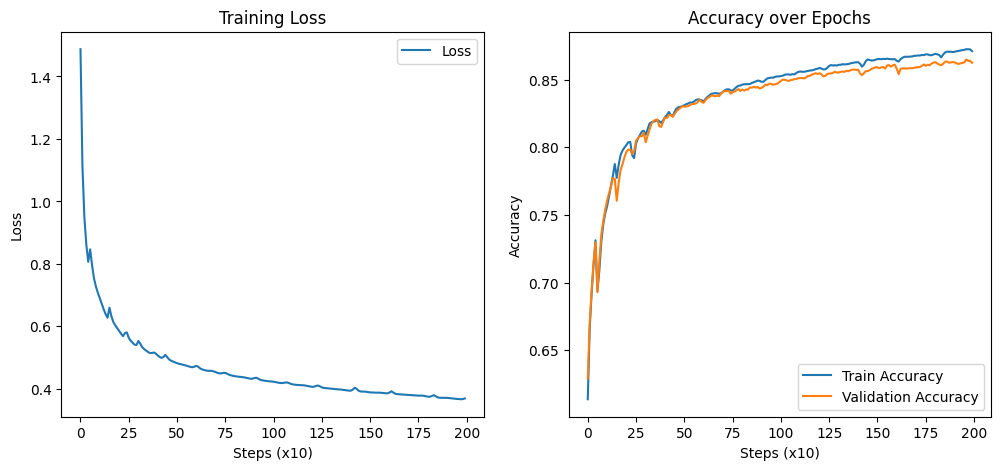

In [32]:
# Huấn luyện mô hình

# Cấu hình siêu tham số
INPUT_SIZE = 784    # 28x28
HIDDEN_SIZE = 128   # Số nơ-ron ẩn, 128 là con số hợp lý cho bài toán này
OUTPUT_SIZE = 10    # 10 lớp
LEARNING_RATE = 0.1
EPOCHS = 2000       # 2000 vòng lặp để đảm bảo hội tụ sâu

# Khởi tạo mô hình
nn_model = SimpleNeuralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, LEARNING_RATE)

# Thực hiện huấn luyện
nn_model.train(X_train, Y_train, X_val, Y_val, epochs=EPOCHS, verbose_freq=200)

# Biểu đồ Accuracy và Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nn_model.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Steps (x10)')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nn_model.history['train_acc'], label='Train Accuracy')
plt.plot(nn_model.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Steps (x10)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
# Đánh giá trên tập Test

# Dự đoán trên tập Test
y_test_pred = nn_model.predict(X_test)

# Accuracy
test_acc = accuracy_score(y_test_labels, y_test_pred)
print(f"Độ chính xác trên tập Test (Accuracy): {test_acc:.4f} ({test_acc*100:.2f}%)")

# Precision, Recall, F1-Score
print("\nBáo cáo :")
print(classification_report(y_test_labels, y_test_pred, digits=4))

# Ma trận nhầm lẫn
print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test_labels, y_test_pred))

Độ chính xác trên tập Test (Accuracy): 0.8640 (86.40%)

Báo cáo :
              precision    recall  f1-score   support

           0     0.7756    0.8986    0.8326       700
           1     0.9740    0.9614    0.9676       700
           2     0.7545    0.7729    0.7636       700
           3     0.8794    0.8643    0.8718       700
           4     0.7135    0.8786    0.7875       700
           5     0.9401    0.9414    0.9408       700
           6     0.7938    0.4786    0.5971       700
           7     0.9278    0.9186    0.9232       700
           8     0.9560    0.9614    0.9587       700
           9     0.9494    0.9643    0.9568       700

    accuracy                         0.8640      7000
   macro avg     0.8664    0.8640    0.8600      7000
weighted avg     0.8664    0.8640    0.8600      7000


Ma trận nhầm lẫn:
[[629   3   8  23   2   0  23   1  11   0]
 [  2 673   1  21   2   1   0   0   0   0]
 [ 11   5 541   2 113   2  22   0   4   0]
 [ 30   7  19 605  23   0  